In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [138]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Mar 26 11:28 kaggle.json


In [5]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

100% 25.7M/25.7M [00:02<00:00, 20.2MB/s]
100% 25.7M/25.7M [00:02<00:00, 10.7MB/s]


In [6]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [2]:
df=pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.iloc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

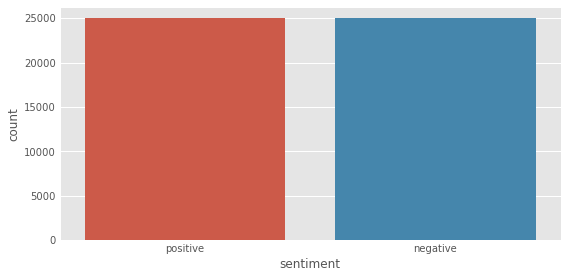

In [142]:
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
sns.countplot(x=df['sentiment'])
plt.show()

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re,string

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
x=df['review']
y=df['sentiment']
stemmer=PorterStemmer()
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [15]:
def custom_standardize(input_data):
    text=tf.strings.lower(input_data)
    text=tf.strings.regex_replace(text,"<br />"," ")
    text=tf.strings.regex_replace(text,f"[{re.escape(string.punctuation)}]","")
    for word in stopwords.words('english'):
        text=tf.strings.regex_replace(text,f' {word} ',"")
    for word in stopwords.words('english'):
        text=tf.strings.regex_replace(text,f' {word} ',f" {stemmer.stem(word)} ")
    return text

In [16]:
from tensorflow.keras.layers import TextVectorization

In [17]:
max_tokens=30000
output_seq_len=500
embedding_dim=128
batch_size=128
time_steps=32

vectorize_layer=TextVectorization(
    standardize=custom_standardize,
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
vectorize_layer.adapt(x)

In [16]:
x=vectorize_layer(x.values)
y=y.map(lambda x:1 if x=='positive' else 0)
x.shape,y.shape

(TensorShape([50000, 500]), (50000,))

In [17]:
data=tf.data.Dataset.from_tensor_slices((x,y))
data=data.cache()
data=data.shuffle(buffer_size=10000)
data=data.batch(batch_size)
data=data.prefetch(tf.data.AUTOTUNE)
data_iterator=data.as_numpy_iterator()

In [18]:
train_data=data.take(int(.8*len(data)))
val_data=data.skip(int(.8*len(data))).take(int(.2*len(data)+1))
print(f'Train size: {len(train_data)},\nValidation size: {len(val_data)},\nTotal size: {len(data)}')

Train size: 312,
Validation size: 79,
Total size: 391


In [19]:
data_iterator.next()

(array([[   11,     1,  1462, ...,     0,     0,     0],
        [   11,  6078,  2514, ...,     0,     0,     0],
        [  137,  1165,  1339, ...,     0,     0,     0],
        ...,
        [26490,     1,     3, ...,     0,     0,     0],
        [    1,     1,   642, ...,     0,     0,     0],
        [ 5740,     1,  2942, ...,     0,     0,     0]], dtype=int64),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64))

In [20]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Dropout

In [21]:
def build_model():
    inputs=Input(shape=(output_seq_len,))
    x=Embedding(max_tokens+1,embedding_dim)(inputs)
    x=Dropout(.2)(x)
    x=Bidirectional(
        LSTM(time_steps,return_sequences=True,dropout=0.2)
    )(x)
    x=Bidirectional(
        LSTM(time_steps,dropout=.2)
    )(x)
    x=Dense(1,activation='sigmoid')(x)

    model=Model(inputs=inputs,outputs=x)
    return model

In [22]:
model=build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          3840128   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          41216     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65    

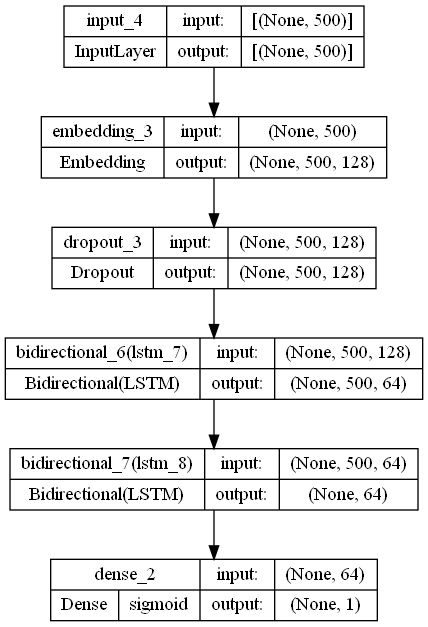

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=96,show_layer_activations=True)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    workers=-1,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs',write_images=True,write_steps_per_second=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7269
Epoch 1: val_loss improved from inf to 0.34150, saving model to ckpt


312/312 [==============================] - 94s 278ms/step - loss: 0.5329 - accuracy: 0.7269 - val_loss: 0.3415 - val_accuracy: 0.8585
Epoch 2/10
312/312 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8722
Epoch 2: val_loss improved from 0.34150 to 0.25017, saving model to ckpt


312/312 [==============================] - 69s 222ms/step - loss: 0.3071 - accuracy: 0.8722 - val_loss: 0.2502 - val_accuracy: 0.9009
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9199
Epoch 3: val_loss improved from 0.25017 to 0.22100, saving model to ckpt


312/312 [==============================] - 62s 197ms/step - loss: 0.2107 - accuracy: 0.9199 - val_loss: 0.2210 - val_accuracy: 0.9205
Epoch 4/10
312/312 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9477
Epoch 4: val_loss improved from 0.22100 to 0.19972, saving model to ckpt


312/312 [==============================] - 61s 196ms/step - loss: 0.1466 - accuracy: 0.9477 - val_loss: 0.1997 - val_accuracy: 0.9274
Epoch 5/10
312/312 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9640
Epoch 5: val_loss improved from 0.19972 to 0.18631, saving model to ckpt


312/312 [==============================] - 54s 174ms/step - loss: 0.1073 - accuracy: 0.9640 - val_loss: 0.1863 - val_accuracy: 0.9340
Epoch 6/10
312/312 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9728
Epoch 6: val_loss improved from 0.18631 to 0.17592, saving model to ckpt


312/312 [==============================] - 54s 172ms/step - loss: 0.0809 - accuracy: 0.9728 - val_loss: 0.1759 - val_accuracy: 0.9394
Epoch 7/10
312/312 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9764
Epoch 7: val_loss improved from 0.17592 to 0.16828, saving model to ckpt


312/312 [==============================] - 51s 162ms/step - loss: 0.0726 - accuracy: 0.9764 - val_loss: 0.1683 - val_accuracy: 0.9398
Epoch 8/10
312/312 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9817
Epoch 8: val_loss improved from 0.16828 to 0.14245, saving model to ckpt


312/312 [==============================] - 53s 169ms/step - loss: 0.0585 - accuracy: 0.9817 - val_loss: 0.1424 - val_accuracy: 0.9556
Epoch 9/10
312/312 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9846
Epoch 9: val_loss improved from 0.14245 to 0.13776, saving model to ckpt


312/312 [==============================] - 49s 158ms/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 0.1378 - val_accuracy: 0.9554
Epoch 10/10
312/312 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9868
Epoch 10: val_loss improved from 0.13776 to 0.13379, saving model to ckpt


312/312 [==============================] - 49s 157ms/step - loss: 0.0436 - accuracy: 0.9868 - val_loss: 0.1338 - val_accuracy: 0.9565


In [ ]:
df=pd.DataFrame(history.history)
df.to_csv('model_metrics.csv')

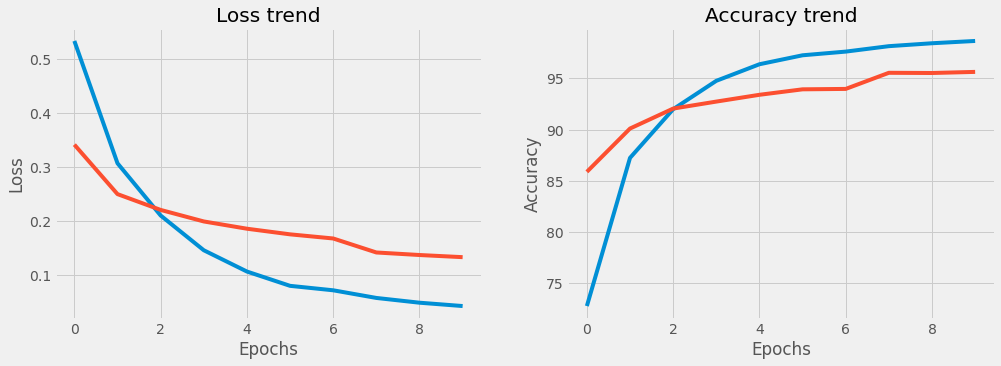

In [144]:
df=pd.read_csv('model_metrics.csv')
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(df['loss'],label='loss')
ax[0].plot(df['val_loss'],label='val loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss trend')

ax[1].plot(df['accuracy']*100,label='accuracy')
ax[1].plot(df['val_accuracy']*100,label='val accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy trend')
plt.show()

In [25]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [ ]:
pre=Precision()
rec=Recall()
acc=BinaryAccuracy()

for batch in val_data.as_numpy_iterator():
    reviews,sentiments=batch
    preds=model.predict(reviews,verbose=0)
    sentiments=sentiments.flatten()
    preds=preds.flatten()
    
    pre.update_state(sentiments,preds)
    rec.update_state(sentiments,preds)
    acc.update_state(sentiments,preds)

print(f'Precision: {pre.result()}')
print(f'Recall: {rec.result()}')
print(f'Binary Accuracy: {acc.result()}')

Precision: 0.9497537016868591
Recall: 0.9618838429450989
Binary Accuracy: 0.9556836485862732


In [ ]:
model.save('metadata')
tf.keras.models.save_model(model,'models/sentiment_classifier-2.0.h5')

In [27]:
model=tf.keras.models.load_model('models/sentiment_classifier-2.0.h5',compile=False)
model.load_weights('ckpt')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.evaluate(val_data)

79/79 [==============================] - 5s 27ms/step - loss: 0.1292 - accuracy: 0.9594


[0.12924830615520477, 0.9593601226806641]

In [28]:
def build_inference_model(model):
    inputs=Input(shape=(1,),dtype='string')
    ids=vectorize_layer(inputs)
    outputs=model(ids)
    model=Model(inputs=inputs,outputs=outputs)
    return model

end2end_model=build_inference_model(model)
end2end_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)
end2end_model.summary()
end2end_model.save('end2end_model')

def get_sentiment(reviews):
    preds=end2end_model(np.array(reviews))
    preds=tf.squeeze(preds,axis=-1)
    temp=[]
    for pred in preds:
        temp.append({'Sentiment':'Positive','Confidence':pred.numpy()*100} if pred>.5 else ({'Sentiment':'Negative','Confidence':(1-pred).numpy()*100}))
    return temp

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 model_2 (Functional)        (None, 1)                 3906241   
                                                                 
Total params: 3,906,241
Trainable params: 3,906,241
Non-trainable params: 0
_________________________________________________________________


## Sentiment classification on random reviews from internet

In [29]:
get_sentiment([
    'This is an absolutely outstanding and beautiful movie, and there wasn’t a single moment or scene in which I lost interest. I am not a movie person to say the least, but after hearing so much good about it from others I decided to check it out. It keeps you hooked and the storyline is something so timeless and unique! What really resonated with me during my first time watching this film was the main character, Ishida’s, personality. Having a character in a movie who lives with anxiety and feeling truly alone is something I could most definitely relate to. ',
    
    '''It’s just horrible.... the mc can’t defend herself from this assault! Like she doesn’t have any grudges or anything is like she forgets the insults and harassment they did.... she is not normal! She always talking to them like they are buddies and why when they ask yui a question she says “well” or “umm” LIKE SAY SOMETHING she barely said anything in most of the episodes of season 1''',
    
    '''Don’t listen to the 0 stars people this anime is beautiful and a great experience (still can’t believe boss baby beat this in the oscars) people saying it’s too long honestly make zero sense. Endgame is 3 hours now is it considered a bad movie because of it, HELL NO it’s considered one of the greatest superhero movies ever made.''',
    '''I'm so done with vampires... and Yui. Why is she such a weakling? Honestly her character frustrates me a lot. I watched this show quite some time ago and honestly I don't know why I did, probably because I was a kid and didn't really understand. honestly I would not recommend this anime :/''',
    
    '''Highly Overrated But Only Good 

However delightful as it is The Shawshank Redemption has no allegories and no statements to make and it brought nothing new to cinema in either style or substance. 
It had no revolutionary ideas or approaches it's only a very safe buddy story A damn good one but still just that. So it can impossibly be a film that will be remembered or studied, because what will it be remembered for Friendship Huh neat At the end of the day Shawshank is a good film but far from a perfect one. '''
])

[{'Sentiment': 'Positive', 'Confidence': 99.22014474868774},
 {'Sentiment': 'Negative', 'Confidence': 52.04205513000488},
 {'Sentiment': 'Positive', 'Confidence': 94.7136402130127},
 {'Sentiment': 'Positive', 'Confidence': 89.47750926017761},
 {'Sentiment': 'Positive', 'Confidence': 98.5156774520874}]